## Multi-head attention transformer
### Encoder and Decoder
### (With masking)


### Inilialsing an Encoder-Decoder transformer with different modules from torch (such as nn.Transformer, nn.Linear, etc)

In [1]:
%%capture
%pip install torch-snippets lovely-tensors lovely-numpy seaborn

In [2]:
from torch_snippets import *
from torch_snippets import AD
import seaborn as sns
from lovely_numpy import lo

In [3]:
def summarize(nparray, ptarray, title):
    print(f'''
Comparing `{title}` arrays -
Numpy   Array: {torch.tensor(nparray, dtype=ptarray.dtype)}
Pytorch Array: {ptarray}
''')

# AD is a fancy wrapper on a dictionary
cfg = AD(
    src_vocab_size=20,
    tgt_vocab_size=20,
    d_model=16,
    num_heads=4,
    num_encoder_layers=1,
    num_decoder_layers=1,
    d_ff=20,
    max_seq_len=5,
    dropout=0
)

src_data = torch.tensor([[2], [1], [5], [4]])
tgt_data = torch.tensor([[1], [16], [5], [3], [9]])

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        # Create a tensor with positions [0, 1, 2, ..., max_len-1]
        position = torch.arange(0, max_len).unsqueeze(1).float()
        # Compute the division term based on the dimension of the model
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        # Apply sine to even indices in the positional encoding
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in the positional encoding
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        # Add an extra dimension to match the batch size (1, max_len, d_model)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return self.encoding[:, :x.size(1)].detach()

<Axes: >

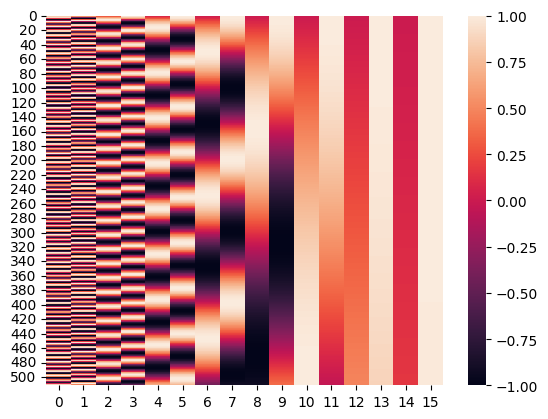

In [5]:
pe = PositionalEncoding(cfg.d_model)
sns.heatmap(pe.encoding.numpy()[0])

In [6]:
class TransformerModel_Enc_Dec(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_encoder_layers, num_decoder_layers, max_seq_len, d_ff, dropout = 0):
        super(TransformerModel_Enc_Dec, self).__init__()
        # Initialize source and target embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Initialize positional encoding
        self.positional_encoding = PositionalEncoding(d_model, dropout=0, max_len=max_seq_len)

        # Initialize the transformer model
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout,
            dim_feedforward=d_ff,
        )

        # Initialize the final fully connected layer to project the output to the target vocabulary size
        self.fc = nn.Linear(d_model, tgt_vocab_size)

    def generate_mask(self, src, tgt):
        # Generate masks for source and target sequences
        src_mask = None # No mask for the source sequence
        seq_length = tgt.size(0)

        # Generate a no-peak mask for the target sequence to prevent attending to future tokens
        nopeak_mask = (torch.triu(torch.ones(seq_length, seq_length), diagonal=1)).bool()
        return src_mask, nopeak_mask

    def forward(self, src, tgt):
        # Generate source and target masks
        src_in = src
        tgt_in = tgt
        src_mask, tgt_mask = self.generate_mask(src, tgt)

        # Embed the source and target sequences and add positional encodings
        src_emb = self.src_embedding(src)
        tgt_emb = self.tgt_embedding(tgt)
        src = src_emb + self.positional_encoding(src)
        tgt = tgt_emb + self.positional_encoding(tgt)

        # Pass the embedded sequences through the transformer model
        transformer_output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask)

        # Apply the final fully connected layer to project the output to the target vocabulary size
        final_output = self.fc(transformer_output)
        return AD(final_output, transformer_output, src_emb, tgt_emb, src, tgt, src_mask, tgt_mask, src_in, tgt_in)


In [7]:
torch.manual_seed(0)

head_dim = cfg.d_model//cfg.num_heads
transformer = TransformerModel_Enc_Dec(**cfg)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
with torch.no_grad():
    pytorch_outputs = o = transformer.forward(src=src_data, tgt=tgt_data[:-1,:])
    pytorch_outputs = AD({k:v[:,0] if isinstance(v,torch.Tensor) else v for k,v in o.items()})
print(pytorch_outputs)


```↯ AttrDict ↯
tgt_in - 🔦tensor[4] i64 x∈[1, 16] μ=6.250 σ=6.702 [1, 16, 5, 3] - ID:#61d6f8
src_in - 🔦tensor[4] i64 x∈[1, 5] μ=3.000 σ=1.826 [2, 1, 5, 4] - ID:#06eaa8
tgt_mask - 🔦tensor[4] bool all_zeros [False, False, False, False] - ID:#df3f61
src_mask - NoneType
tgt - 🔦tensor[4, 16] n=64 x∈[-2.349, 4.930] μ=0.555 σ=1.237 - ID:#4fef04
src - 🔦tensor[4, 16] n=64 x∈[-1.882, 3.567] μ=0.576 σ=1.248 - ID:#9eb293
tgt_emb - 🔦tensor[4, 16] n=64 x∈[-2.733, 3.930] μ=0.055 σ=1.190 - ID:#94b438
src_emb - 🔦tensor[4, 16] n=64 x∈[-1.882, 2.567] μ=0.076 σ=1.019 - ID:#823c8c
transformer_output - 🔦tensor[4, 16] n=64 x∈[-2.150, 1.932] μ=-9.313e-09 σ=1.008 - ID:#f91b8b
final_output - 🔦tensor[4, 20] n=80 x∈[-1.295, 1.310] μ=0.009 σ=0.615 - ID:#0eddc3

```



In [9]:
state_dict = transformer.state_dict()

## **Manual computation of each layer of the transformer**

### 1. Source token embeddings

In [10]:
class NumpyEmbeddingLayer:
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def __call__(self, tokens):
        return np.array([self.embeddings[t][0] for t in tokens])

In [11]:
src_embedding_layer = NumpyEmbeddingLayer(state_dict["src_embedding.weight"])
src_embedding = src_embedding_layer(src_data)
summarize(src_embedding, pytorch_outputs.src_emb, 'Source Token Embeddings')


Comparing `Source Token Embeddings` arrays -
Numpy   Array: tensor[4, 16] n=64 x∈[-1.882, 2.567] μ=0.076 σ=1.019
Pytorch Array: tensor[4, 16] n=64 x∈[-1.882, 2.567] μ=0.076 σ=1.019



### 2. Source token embeddings + positional embeddings

Redefining the Positonal Embeddings class into the numpy version

In [12]:
import numpy as np

class NpPositionalEncoding:
    def __init__(self, d_model, max_len=512, dropout=0):
        self.encoding = np.zeros((max_len, d_model))
        position = np.arange(0, max_len).reshape(-1, 1).astype(np.float32)
        div_term = np.exp(np.arange(0, d_model, 2).astype(np.float32) * -(np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = np.sin(position * div_term)
        self.encoding[:, 1::2] = np.cos(position * div_term)
        self.encoding = self.encoding[np.newaxis, :]

    def __call__(self, x):
        return self.encoding[0][0]

In [13]:
pe = NpPositionalEncoding(d_model=cfg.d_model, max_len=cfg.max_seq_len)

# Compute the positional encodings for the source data and add them to the source embeddings
pe_src_embeds = src_embedding + pe(src_data)
summarize(pe_src_embeds, pytorch_outputs.src, 'Positional Source Embeddings')


Comparing `Positional Source Embeddings` arrays -
Numpy   Array: tensor[4, 16] n=64 x∈[-1.882, 3.567] μ=0.576 σ=1.248
Pytorch Array: tensor[4, 16] n=64 x∈[-1.882, 3.567] μ=0.576 σ=1.248



### 3. Q,K,V matrices from the model's intialised weights

We define a function for getting these vectors in any number of layers in the encoder or decoder

In [14]:
import numpy as np

def get_QKV_matrices(x, layer_num, state_dict, num_heads, is_decoder=False):
    """
    Extracts the Q, K, and V matrices from the encoded input for a given transformer layer.

    Args:
    - x: Encoded input tensor (numpy array).
    - layer_num: Layer number from which to extract the Q, K, and V matrices.
    - state_dict: Dictionary containing the model weights.
    - num_heads: Number of attention heads.
    - is_decoder: Boolean indicating if the layer is in the decoder.

    Returns:
    - Q: Query matrix after reshaping.
    - K: Key matrix after reshaping.
    - V: Value matrix after reshaping.
    """

    # Set query, key, and value encoding to the input encoding
    query = key = value = x

    # Determine the target length and embedding dimension from the input encoding
    tgt_len, embed_dim = x.shape

    # Determine the layer type (encoder or decoder) and extract the weights and biases accordingly
    layer_type = "decoder" if is_decoder else "encoder"
    W = state_dict[f"transformer.{layer_type}.layers.{layer_num}.self_attn.in_proj_weight"].numpy()
    b = state_dict[f"transformer.{layer_type}.layers.{layer_num}.self_attn.in_proj_bias"].numpy()

    # Calculate the dimension for each attention head
    head_dim = embed_dim // num_heads

    # Compute the product of the input encoding and the transpose of the weight matrix
    tempop1 = query @ W.T

    # Split the resulting matrix into Q, K, and V matrices
    Q = tempop1[:, 0:embed_dim]
    K = tempop1[:, embed_dim:2*embed_dim]
    V = tempop1[:, 2*embed_dim:3*embed_dim]

    # Print the shapes of the Q, K, and V matrices
    print("Q_shape = ", Q.shape)
    print("K_shape = ", K.shape)
    print("V_shape = ", V.shape)
    print()

    print("After reshaping... \n")

    # Reshape and transpose the Q, K, and V matrices for multi-head attention
    Q = np.transpose(np.reshape(Q, (tgt_len, num_heads, head_dim)), (1, 0, 2))
    K = np.transpose(np.reshape(K, (K.shape[0], num_heads, head_dim)), (1, 0, 2))
    V = np.transpose(np.reshape(V, (V.shape[0], num_heads, head_dim)), (1, 0, 2))

    # Print the shapes of the reshaped Q, K, and V matrices
    print("Q_shape = ", Q.shape)
    print("K_shape = ", K.shape)
    print("V_shape = ", V.shape)

    return Q, K, V

In [58]:
x_enc = pe_src_embeds
tgt_len, embed_dim = x_enc.shape

Q_enc , K_enc, V_enc =  get_QKV_matrices(x=x_enc, layer_num=0, state_dict=state_dict, num_heads=cfg.num_heads, is_decoder=False)
lo(Q_enc), lo(K_enc), lo(V_enc)

Q_shape =  (4, 16)
K_shape =  (4, 16)
V_shape =  (4, 16)

After reshaping... 

Q_shape =  (4, 4, 4)
K_shape =  (4, 4, 4)
V_shape =  (4, 4, 4)


(array[4, 4, 4] n=64 x∈[-2.202, 2.078] μ=0.098 σ=0.962,
 array[4, 4, 4] n=64 x∈[-2.223, 2.017] μ=0.016 σ=0.916,
 array[4, 4, 4] n=64 x∈[-2.220, 2.065] μ=0.270 σ=0.858)

### 4. Self-Attention in the Enocder

In [16]:
import numpy as np
import math

def calculate_attention(Q, K, V, attn_mask = None):
    """
    Calculates the scaled dot-product attention for a given set of Q, K, and V matrices.

    Args:
    - Q: Query matrix.
    - K: Key matrix.
    - V: Value matrix.

    Returns:
    - attn_output: Output of the attention calculation.
    """

    # Calculate the scale factor for the dot product
    scale_factor = 1 / math.sqrt(Q.shape[-1])
    # Transpose the K matrix for matrix multiplication
    K_T = np.transpose(K, axes=(0, 2, 1))
    # Calculate the scaled dot product of Q and K
    attn_weight = Q @ K_T * scale_factor
    if attn_mask is not None:
        attn_weight += attn_mask

    # Apply softmax to the attention weights
    exp_attn_weight = np.exp(attn_weight)
    sum_exp_attn_weight = np.sum(exp_attn_weight, axis=-1, keepdims=True)
    softmax_attn_weight = exp_attn_weight / sum_exp_attn_weight
    # Calculate the attention output
    attn_output = softmax_attn_weight @ V
    return attn_output

In [17]:
# Calculate attention
attn_output_enc = calculate_attention(Q_enc, K_enc, V_enc)

In [18]:
torch.Tensor(attn_output_enc)

tensor[4, 4, 4] n=64 x∈[-0.971, 1.466] μ=0.242 σ=0.526

In [19]:
def reshape_attention_op(attn_output, num_heads, tgt_len, head_dim):
    """
    Reshapes the attention output matrix to match the desired shape.

    Args:
    - attn_output: Attention output matrix.
    - num_heads: Number of attention heads.
    - tgt_len: Length of the target sequence.
    - head_dim: Dimension of each attention head.

    Returns:
    - final_attn_sa_op: Reshaped attention output.
    """

    # Transpose the attention output dimensions
    attn_output_permuted_sa = np.transpose(attn_output, axes=(0, 1, 2))

    # Compute the number of elements in the reshaped output
    numh_tgt_len, embed_dim = num_heads * tgt_len, head_dim

    # Reshape the attention output
    attn_output_reshaped_sa = attn_output_permuted_sa.reshape(numh_tgt_len, embed_dim)

    # Initialize the final attention output matrix with zeros
    final_attn_sa_op = np.zeros(attn_output_reshaped_sa.shape)

    i = 0

    while i < attn_output_reshaped_sa.shape[1]:
        for j in range(attn_output_reshaped_sa.shape[1]):
            # Compute the position in the final matrix
            pos = i * attn_output_reshaped_sa.shape[1] + j
            # Compute the block index and offset for the current column
            blk = j * attn_output_reshaped_sa.shape[1]
            offset = i
            # Assign the corresponding value from the reshaped attention output to the final matrix
            final_attn_sa_op[pos] = attn_output_reshaped_sa[blk + offset]
        i += 1
    final_attn_sa_op = final_attn_sa_op.reshape(attn_output_reshaped_sa.shape[1], -1)
    return final_attn_sa_op


In [20]:
attn_sa_enc = reshape_attention_op(attn_output_enc, cfg.num_heads, tgt_len, head_dim)

In [21]:
torch.Tensor(attn_sa_enc)

tensor[4, 16] n=64 x∈[-0.971, 1.466] μ=0.242 σ=0.526

### 5. Post self attention in the encoder block

In [22]:
import numpy as np

def attention_output_projection(final_attn_sa_op, state_dict, layer_num, is_decoder = False, is_crossattn = False):
    """
    Perform the attention output projection.

    Args:
    - final_attn_sa_op: Reshaped attention output tensor.
    - state_dict: State dictionary containing the parameters of the model.
    - layer_num: Index of the encoder layer.

    Returns:
    - output_enc_1: Output of the attention output projection.
    """
    # Obtain the parameters for the attention output projection
    layer_type = "decoder" if is_decoder else "encoder"
    attn_type = "multihead_attn" if is_crossattn else "self_attn"

    weight_key = "transformer.{}.layers.{}.{}.out_proj.weight".format(layer_type, layer_num, attn_type)
    bias_key = "transformer.{}.layers.{}.{}.out_proj.bias".format(layer_type, layer_num, attn_type)

    weight_op = state_dict[weight_key].numpy()
    bias_op = state_dict[bias_key].numpy()

    # Output projection of the attention values
    output_1 = np.matmul(final_attn_sa_op, weight_op.T) + bias_op

    return output_1

def layer_norm(input_tensor, state_dict, layer_num, suffix, is_decoder=False):
    """
    Apply layer normalization.

    Args:
    - input_tensor: Input tensor to be normalized.
    - state_dict: State dictionary containing the parameters of the model.
    - layer_num: Index of the encoder layer.
    - suffix: Suffix for parameter keys.

    Returns:
    - normalized_tensor: Normalized tensor.
    """

    layer_type = "decoder" if is_decoder else "encoder"

    weight_key = "transformer.{}.layers.{}.{}.weight".format(layer_type, layer_num, suffix)
    bias_key = "transformer.{}.layers.{}.{}.bias".format(layer_type, layer_num, suffix)

    norm_weight = state_dict[weight_key].numpy()
    norm_bias = state_dict[bias_key].numpy()

    linear_result = input_tensor * norm_weight + norm_bias

    # Compute mean and standard deviation for Layer Norm
    mean = np.mean(linear_result, axis=-1, keepdims=True)
    std = np.std(linear_result, axis=-1, keepdims=True)
    epsilon = 1e-5
    normalized_tensor = (linear_result - mean) / (std + epsilon)
    return normalized_tensor

def linear_relu_linear(input_tensor, state_dict, layer_num, is_decoder=False):
    """
    Apply Linear-Relu-Linear projection.

    Args:
    - input_tensor: Input tensor to be projected.
    - state_dict: State dictionary containing the parameters of the model.
    - layer_num: Index of the encoder layer.

    Returns:
    - output_enc_final: Output tensor after Linear-Relu-Linear projection.
    """

    # Obtain the parameters for the linear projections
    layer_type = "decoder" if is_decoder else "encoder"

    weight1_key = "transformer.{}.layers.{}.linear1.weight".format(layer_type, layer_num)
    bias1_key = "transformer.{}.layers.{}.linear1.bias".format(layer_type, layer_num)
    weight2_key = "transformer.{}.layers.{}.linear2.weight".format(layer_type, layer_num)
    bias2_key = "transformer.{}.layers.{}.linear2.bias".format(layer_type, layer_num)

    linear1_weight = state_dict[weight1_key].numpy()
    linear1_bias = state_dict[bias1_key].numpy()
    linear2_weight = state_dict[weight2_key].numpy()
    linear2_bias = state_dict[bias2_key].numpy()

    # Linear projection 1
    op_enc_1 = np.matmul(input_tensor, linear1_weight.T) + linear1_bias
    # ReLU activation
    op_enc_1_relu = np.maximum(op_enc_1, 0)
    # Linear projection 2
    op_enc_2 = np.matmul(op_enc_1_relu, linear2_weight.T) + linear2_bias
    return op_enc_2

def encoder_layer_forward(x_enc, final_attn_sa_op, state_dict, layer_num):
    """
    Forward pass through an encoder layer of a Transformer model.

    Args:
    - x_enc: Input tensor for the encoder layer.
    - final_attn_sa_op: Reshaped attention output tensor.
    - state_dict: State dictionary containing the parameters of the model.
    - layer_num: Index of the encoder layer.

    Returns:
    - output_enc_final: Output tensor of the encoder layer.
    """

    # Attention output projection
    output_enc_1 = attention_output_projection(final_attn_sa_op, state_dict, layer_num)

    # Residual connection 1
    output_enc_1 += x_enc

    # Layer Norm 1
    normalized_tensor_1 = layer_norm(output_enc_1, state_dict, layer_num, "norm1")

    # Linear-Relu-Linear projection
    output_enc_2 = linear_relu_linear(normalized_tensor_1, state_dict, layer_num)

    # Residual connection 2
    output_enc_2 += normalized_tensor_1

    # Layer Norm 2
    output_enc_final = layer_norm(output_enc_2, state_dict, layer_num, "norm2")

    return output_enc_final


In [23]:
output_enc_final = encoder_layer_forward(x_enc, attn_sa_enc, state_dict, layer_num = 0)

In [24]:
torch.Tensor(output_enc_final)

tensor[4, 16] n=64 x∈[-2.116, 2.310] μ=0. σ=1.008

In [25]:
x_enc = output_enc_final

## Decoder block


### Self attention outputs from a decoder block

### 6. Target token embeddings

In [26]:
# Considering only the tokens except the last one for the next word prediction (auto-regressive task)
tgt_data1 = tgt_data[:-1,:]

tgt_embedding_layer = NumpyEmbeddingLayer(state_dict["tgt_embedding.weight"])
tgt_embedding = tgt_embedding_layer(tgt_data1)

# Print the shape of tgt_embedding
summarize(tgt_embedding, pytorch_outputs.tgt_emb, 'Target Token Embeddings')



Comparing `Target Token Embeddings` arrays -
Numpy   Array: tensor[4, 16] n=64 x∈[-2.733, 3.930] μ=0.055 σ=1.190
Pytorch Array: tensor[4, 16] n=64 x∈[-2.733, 3.930] μ=0.055 σ=1.190



### 7. Target token embeddings + positional embeddings

In [27]:
pe = NpPositionalEncoding(d_model=cfg.d_model, max_len=cfg.max_seq_len)
pe_tgt_embeds = tgt_embedding + pe(tgt_data)

summarize(pe_tgt_embeds, pytorch_outputs.tgt, 'Positional Target Embeddings')


Comparing `Positional Target Embeddings` arrays -
Numpy   Array: tensor[4, 16] n=64 x∈[-2.349, 4.930] μ=0.555 σ=1.237
Pytorch Array: tensor[4, 16] n=64 x∈[-2.349, 4.930] μ=0.555 σ=1.237



In [28]:
x_dec = pe_tgt_embeds

### 8. Self Attention in Decoder **(with mask)**

In [29]:
seq_length = 4
tgt_mask = np.triu(np.ones((seq_length, seq_length)), k=1).astype('bool')

tgt_mask

array([[False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False, False,  True],
       [False, False, False, False]])

In [30]:
Q_dec , K_dec, V_dec =  get_QKV_matrices(x = x_dec, layer_num = 0, state_dict = state_dict, num_heads = cfg.num_heads, is_decoder=True)

Q_shape =  (4, 16)
K_shape =  (4, 16)
V_shape =  (4, 16)

After reshaping... 

Q_shape =  (4, 4, 4)
K_shape =  (4, 4, 4)
V_shape =  (4, 4, 4)


In [31]:
torch.Tensor(K_dec)

tensor[4, 4, 4] n=64 x∈[-2.898, 2.246] μ=-0.110 σ=0.949

### Preparing the mask for decoder attention mechanism

In [32]:
# Initialize an attention mask with zeros having the same shape as tgt_mask
attn_mask = np.zeros(tgt_mask.shape)

if tgt_mask is not None:
    if tgt_mask.dtype == 'bool':
        # Convert boolean mask to a float mask with -inf for True and 0 for False
        masked_tensor = tgt_mask.astype(float)
        masked_tensor[masked_tensor == 1] = -np.inf
        tgt_mask = masked_tensor
        attn_mask += tgt_mask
    else:
        # If tgt_mask's dtype is not boolean, directly add tgt_mask to the attention mask
        attn_mask += tgt_mask


In [33]:
attn_mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [34]:
self_attn_output_dec = calculate_attention(Q_dec, K_dec, V_dec, attn_mask = attn_mask)

In [35]:
torch.Tensor(self_attn_output_dec)

tensor[4, 4, 4] n=64 x∈[-2.291, 1.806] μ=-0.125 σ=0.935

In [36]:
attn_sa_dec = reshape_attention_op(self_attn_output_dec, cfg.num_heads, tgt_len, head_dim)

In [37]:
torch.Tensor(attn_sa_dec)

tensor[4, 16] n=64 x∈[-2.291, 1.806] μ=-0.125 σ=0.935

### 9. Post self attention in the decoder self attention block

In [38]:
def decoder_layer_forward1(x_dec, final_attn_sa_op, state_dict, layer_num):
    # Attention output projection
    output_dec_1 = attention_output_projection(final_attn_sa_op, state_dict, layer_num,is_decoder = True)

    # Residual connection 1
    output_dec_1 += x_dec

    # Layer Norm 1
    normalized_tensor_1 = layer_norm(output_dec_1, state_dict, layer_num, "norm1", is_decoder = True)
    return normalized_tensor_1


In [39]:
output_dec_1 = decoder_layer_forward1(x_dec, attn_sa_dec, state_dict, layer_num = 0)

In [40]:
torch.Tensor(output_dec_1)

tensor[4, 16] n=64 x∈[-2.665, 2.617] μ=-1.490e-08 σ=1.008

### 10.**Cross attention** in decoder

In [41]:
memory = x_enc

In [42]:
query_dec_ca = output_dec_1
key_dec_ca, value_dec_ca = memory, memory

In [43]:
def get_QKV_crossattn(query_tensor, key_tensor, state_dict, layer_num, num_heads):
    """
    Compute the Q, K, and V matrices for cross-attention.

    Args:
    - query_tensor: The query tensor for cross-attention.
    - key_tensor: The key tensor for cross-attention.
    - state_dict: State dictionary containing the parameters of the model.
    - layer_num: Index of the decoder layer.
    - num_heads: Number of attention heads.

    Returns:
    - Q: Query matrix for cross-attention.
    - K: Key matrix for cross-attention.
    - V: Value matrix for cross-attention.
    """
    # Get the shape of the query tensor
    tgt_len, embed_dim = query_tensor.shape

    # Obtain the weight and bias matrices for in-projection
    W_dec_ca = state_dict["transformer.decoder.layers.{}.multihead_attn.in_proj_weight".format(layer_num)].numpy()
    b_dec_ca = state_dict["transformer.decoder.layers.{}.multihead_attn.in_proj_bias".format(layer_num)].numpy()

    # Compute the dimension of each attention head
    head_dim = embed_dim // num_heads

    # Compute the dimension of embeddings
    E = query_tensor.shape[-1]

    # Split the weight matrix into W_q and W_kv
    split_indices = [E, E * 2]
    W_q = W_dec_ca[:split_indices[0], :]
    W_kv = W_dec_ca[split_indices[0]:, :]

    # Compute Q matrix
    Q = np.matmul(query_tensor, W_q.T)

    # Compute K and V matrices
    KV_op = np.matmul(key_tensor, W_kv.T)
    K, V = KV_op[:, 0:embed_dim], KV_op[:, embed_dim:2*embed_dim]

    # Reshape Q, K, and V matrices
    Q = np.transpose(np.reshape(Q, (tgt_len, num_heads, head_dim)), (1, 0, 2))
    K = np.transpose(np.reshape(K, (K.shape[0], num_heads, head_dim)), (1, 0, 2))
    V = np.transpose(np.reshape(V, (V.shape[0], num_heads, head_dim)), (1, 0, 2))

    return Q, K, V

In [44]:
layer_num = 0

Q_dec1, K_dec1, V_dec1 = get_QKV_crossattn(query_dec_ca, key_dec_ca, state_dict, layer_num, cfg.num_heads)


In [45]:
# V_dec1
K_dec_ca1_T = np.transpose(K_dec1, axes=(0, 2, 1))

In [46]:
cross_attn_output_dec = calculate_attention(Q_dec1, K_dec1, V_dec1)

In [47]:
torch.Tensor(cross_attn_output_dec)

tensor[4, 4, 4] n=64 x∈[-0.837, 0.799] μ=-0.200 σ=0.413

In [48]:
attn_ca_dec = reshape_attention_op(cross_attn_output_dec, cfg.num_heads, tgt_len, head_dim)

In [49]:
torch.Tensor(attn_ca_dec)

tensor[4, 16] n=64 x∈[-0.837, 0.799] μ=-0.200 σ=0.413

### 11. Post cross attention in the decoder block

In [50]:
def decoder_layer_forward2(self_attn_dec, final_attn_ca_op, state_dict, layer_num):
    # Attention output projection
    output_dec_1 = attention_output_projection(final_attn_ca_op, state_dict, layer_num,is_decoder = True, is_crossattn = True)

    # Residual connection 2
    output_dec_1 += self_attn_dec

    # Layer Norm 1
    normalized_tensor_2 = layer_norm(output_dec_1, state_dict, layer_num, "norm2", is_decoder = True)
    output_dec_2 = linear_relu_linear(normalized_tensor_2, state_dict, layer_num, is_decoder = True)
    ff_dec = output_dec_2

    # Residual connection 3
    output_dec_3 = normalized_tensor_2 + ff_dec

    # Layer Norm 3
    output_dec_3 = layer_norm(output_dec_3, state_dict, layer_num, "norm3", is_decoder = True)
    return output_dec_3


In [51]:
linear_op_dec_3 = decoder_layer_forward2(output_dec_1, attn_ca_dec, state_dict, layer_num)

In [52]:
summarize(linear_op_dec_3, pytorch_outputs.transformer_output, 'Transformer output')


Comparing `Transformer output` arrays -
Numpy   Array: tensor[4, 16] n=64 x∈[-2.150, 1.932] μ=1.304e-08 σ=1.008
Pytorch Array: tensor[4, 16] n=64 x∈[-2.150, 1.932] μ=-9.313e-09 σ=1.008



### 12. Feed Forward Layer

In [53]:
dec_output_final = linear_op_dec_3

In [54]:
W_ff = state_dict["fc.weight"].numpy()
b_ff = state_dict["fc.bias"].numpy()

final_op = dec_output_final@W_ff.T + b_ff

In [56]:
summarize(final_op, pytorch_outputs.final_output, 'Final output')


Comparing `Final output` arrays -
Numpy   Array: tensor[4, 20] n=80 x∈[-1.295, 1.310] μ=0.009 σ=0.615
Pytorch Array: tensor[4, 20] n=80 x∈[-1.295, 1.310] μ=0.009 σ=0.615

